### Feature Selection -- RFE


In [1]:
# Load necessary libraries. 
import os 
import tqdm
import random 
import numpy as np 
import pandas as pd 
import sklearn.metrics as metrics
import shap 

# import our models 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier 

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
threshold = 45          # can change threshold at certain window ... 
nc_path = "data/SHSRdata/"
csv_path = "data/"
cls_names = { "torn":0, "wind":1, "hail":2 }

vars = [ 'temp', 'humidity', 'dew', 'precip', 'preciptype', 'windspeed', 'winddir', 'pressure', 'cloudcover', 'visibility']
stat_vars = [ "mean", "max", "min", "var", "nonzeros", "above_threshold" ]
vars += stat_vars

def read_data( csv, vars, set='train' ):
    dframe = pd.read_csv( csv )
    x = dframe[ dframe['set']==set ][vars]
    y = dframe[ dframe['set']==set ]['label'].values        
    return x,y 

In [3]:
# Choose the Data we will use for training and test.
csv_file = "balanced_comb.csv"
train_x, train_y = read_data( csv_path + "/" + csv_file, vars, set="train" )
print( f"The number of data points in train set:\n", train_x.shape, train_y.shape )
print( type(train_x), type(train_y) ) 
val_x, val_y = read_data( csv_path + "/" + csv_file, vars, set="val" )
print( f"The number of data points in val set:\n", val_x.shape, val_y.shape )
test_x, test_y = read_data( csv_path + "/" + csv_file, vars, set="test" )
print( f"The number of data points in test set:\n", test_x.shape, test_y.shape )

# train_x, train_y, val_x, val_y, test_x, test_y = read_data( csv_path + "/" + csv_file, vars, random_balanced = True )  
# print( f"The number of data points in train set:\n", train_x.shape, train_y.shape )

The number of data points in train set:
 (2730, 16) (2730,)
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
The number of data points in val set:
 (679, 16) (679,)
The number of data points in test set:
 (683, 16) (683,)


## 2. Light GBM with Recursive Feature Elimination 

In this section, we will only use RFE and try to find the best feature combinations with the help of a performance plot.

In [4]:
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 

def evaluate( model, train_x, train_y, test_x, test_y, show_plot=True ):
    """ uses the model to calculate a set of scores """
    train_pred_y = model.predict(train_x)
    print('Training Accuracy    :',accuracy_score( train_y, train_pred_y ))
    pred_y = model.predict(test_x)
    accuracy = accuracy_score( test_y, pred_y )
    precision = precision_score( test_y, pred_y, average=None, zero_division=True )
    recall = recall_score( test_y, pred_y, average=None )
    f1 = f1_score( test_y, pred_y, average=None)
    print('Testing accuracy :', accuracy )
    print('Testing precision :', precision )
    print('Testing recall    :', recall )
    print('F1 score          :', f1 )
    # ROC AUC
    probs=model.predict_proba(test_x) 
    print('ROC AUC           : %f' % roc_auc_score(test_y, probs, average="weighted", multi_class='ovo'))
    conf_mat = confusion_matrix( test_y, pred_y, normalize='true' )
    disp = ConfusionMatrixDisplay(conf_mat, display_labels=["torn", "wind", "hail"])
    disp = disp.plot(cmap=plt.cm.Blues)   # ,values_format='g'
    if show_plot:
        plt.show()
    return accuracy

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_performances( name, nums, val_accs, test_accs ):
    plt.figure(figsize=(16, 10), dpi=50)
    plt.plot(nums, val_accs, c='blue', label='Training Accuracy')
    plt.plot(nums, test_accs, c='red', label='Validation Accuracy')
    plt.rcParams.update({'font.size': 15})
    plt.legend(loc='upper left') 

    plt.xlim( nums[0]-1, nums[-1]+1 )
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Number of Selected Features", fontdict={'size': 30})
    plt.ylabel("Accuracy", fontdict={'size': 30})
    plt.title(f"RFE for {name}: Accuracy Performance vs Feature Number", fontdict={'size': 30})
    plt.show()
    

### Load Necessary Dependencies 

In [6]:
from operator import itemgetter
from boruta import BorutaPy   # doesn't work for now ... 
from shaphypetune import BoostBoruta
from sklearn.feature_selection import RFE
from feature_engine.selection import RecursiveFeatureAddition   # the only RFA I've found ... 

### LightGBM Model with RFE (with a line plot)

Through observing the performance plot, we can find the proper number of features that we would like to select.

============================= Original LightGBM =============================
Training Accuracy    : 0.9989010989010989
Testing accuracy : 0.7306002928257687
Testing precision : [0.77419355 0.69642857 0.7231405 ]
Testing recall    : [0.74008811 0.70588235 0.74468085]
F1 score          : [0.75675676 0.7011236  0.73375262]
ROC AUC           : 0.876001


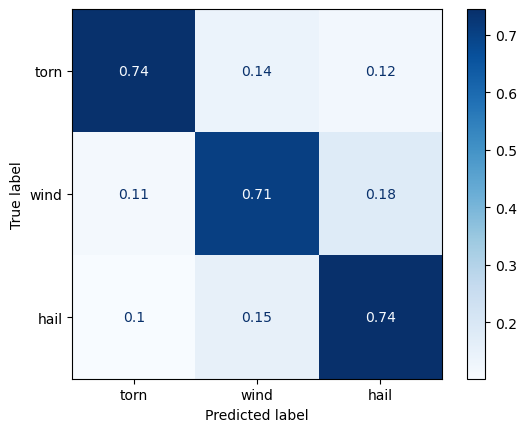

Cross Validation with Validation Set Below:
Training Accuracy    : 0.9989010989010989
Testing accuracy : 0.711340206185567
Testing precision : [0.76712329 0.6745283  0.69354839]
Testing recall    : [0.74008811 0.64705882 0.74458874]
F1 score          : [0.75336323 0.66050808 0.71816284]
ROC AUC           : 0.872452


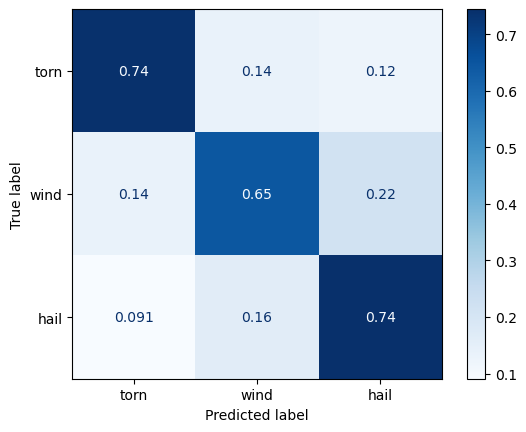

============================= LightGBM with RFE =============================
With 5 features.
Training Accuracy    : 0.9985347985347985
Testing accuracy : 0.6588579795021962
Testing precision : [0.67083333 0.65700483 0.64830508]
Testing recall    : [0.7092511  0.61538462 0.65106383]
F1 score          : [0.68950749 0.63551402 0.64968153]
ROC AUC           : 0.817788
Cross Validation with Validation Set Below:
Training Accuracy    : 0.9985347985347985
Testing accuracy : 0.6553755522827688
Testing precision : [0.69432314 0.61137441 0.65690377]
Testing recall    : [0.70044053 0.58371041 0.67965368]
F1 score          : [0.69736842 0.59722222 0.66808511]
ROC AUC           : 0.807990
With 6 features.
Training Accuracy    : 0.9985347985347985
Testing accuracy : 0.6896046852122987
Testing precision : [0.7167382  0.67757009 0.67372881]
Testing recall    : [0.73568282 0.6561086  0.67659574]
F1 score          : [0.72608696 0.66666667 0.67515924]
ROC AUC           : 0.832542
Cross Validation with 

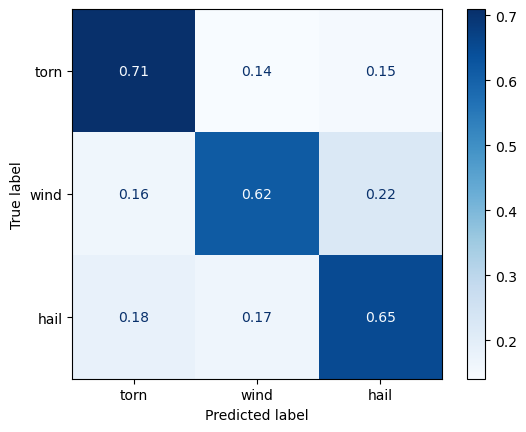

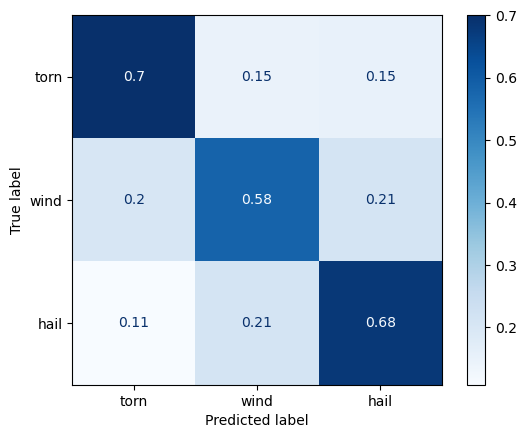

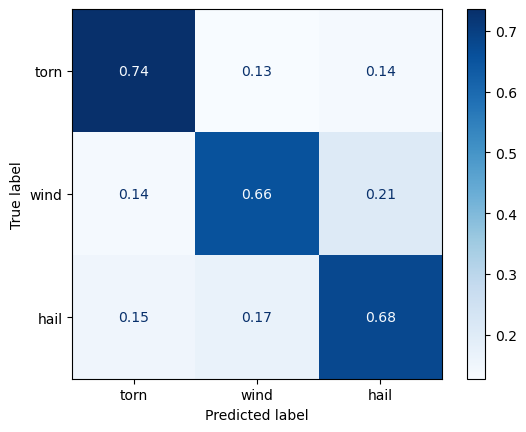

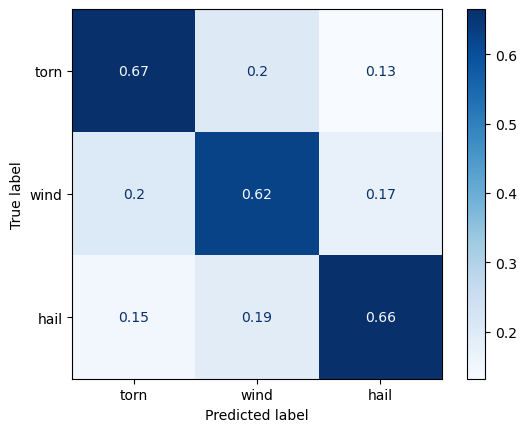

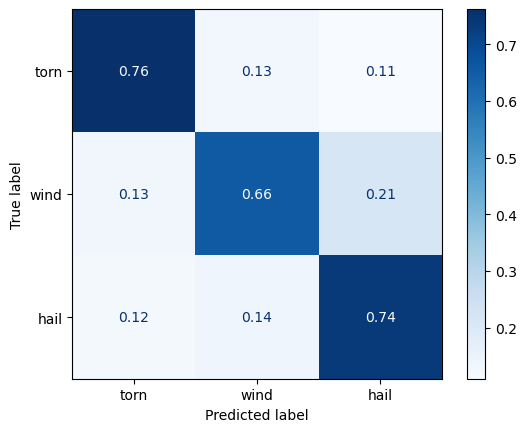

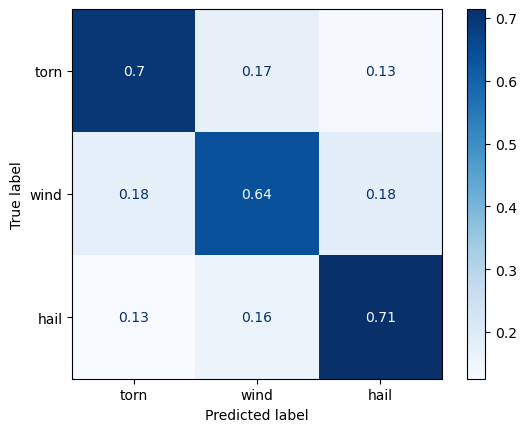

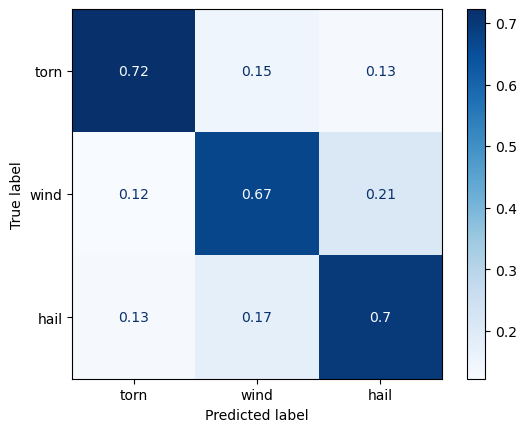

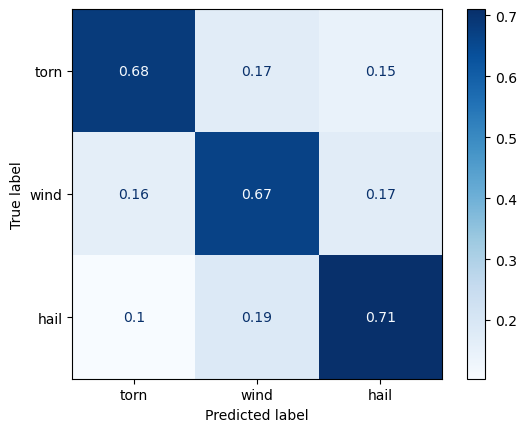

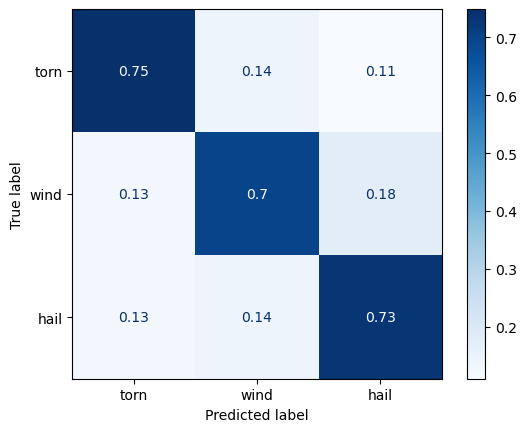

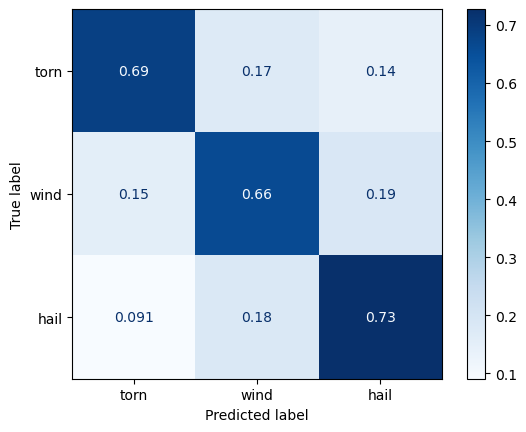

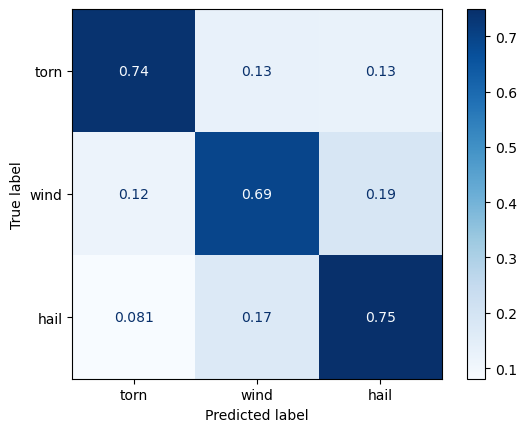

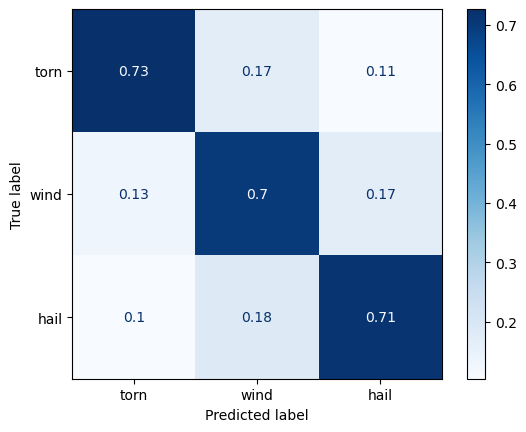

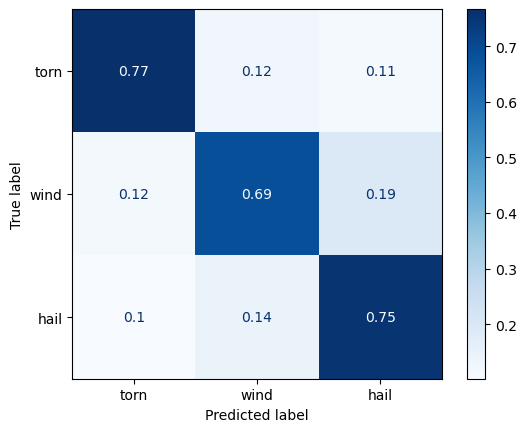

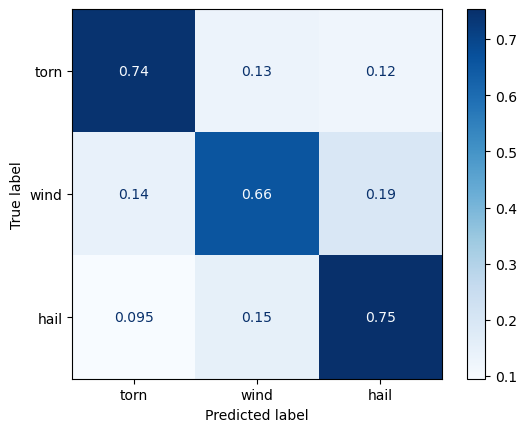

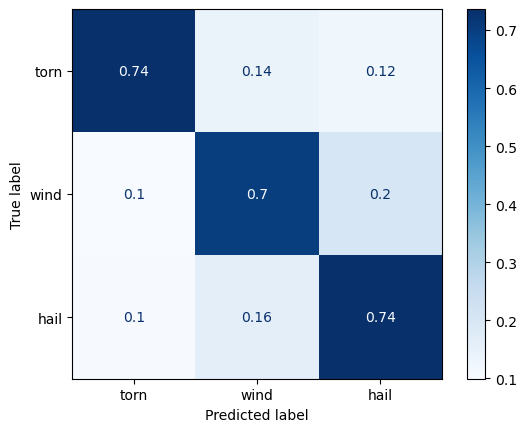

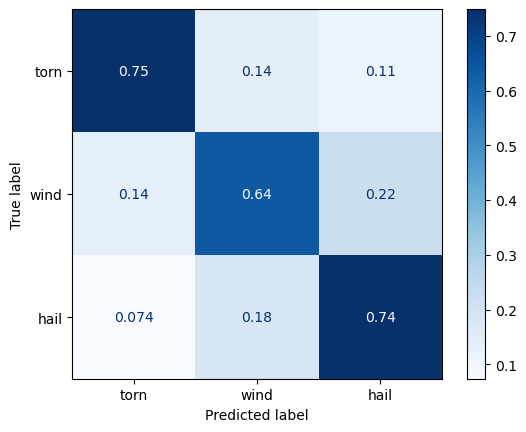

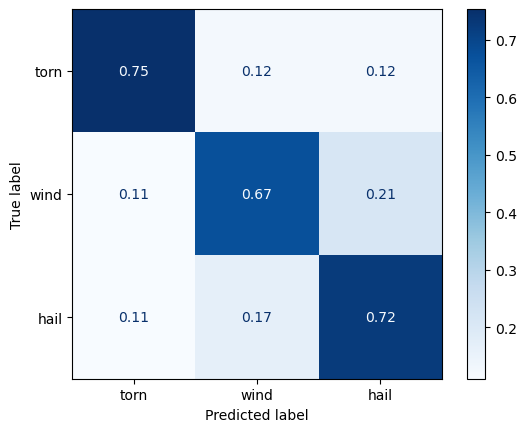

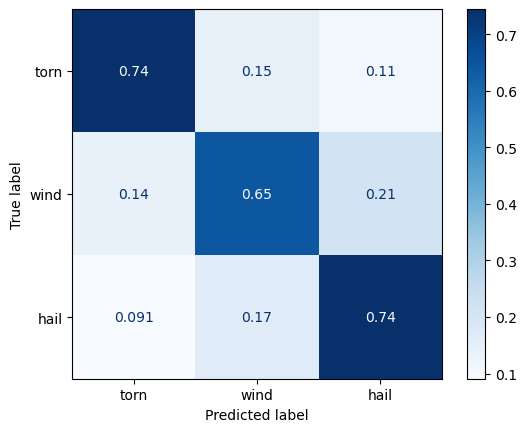

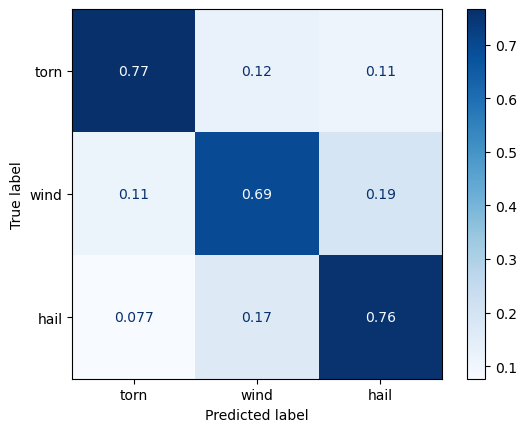

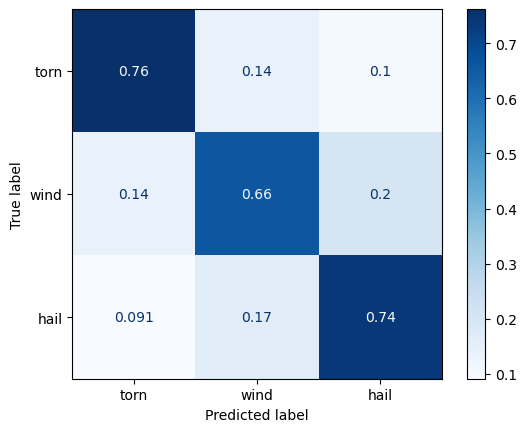

In [7]:
print('============================= Original LightGBM =============================')
lgb = LGBMClassifier( n_estimators=500, verbose=-1 )
lgb.fit(train_x, train_y)
evaluate( lgb, train_x, train_y, test_x, test_y )
print( "Cross Validation with Validation Set Below:" )
evaluate(lgb, train_x, train_y, val_x, val_y) 

print('============================= LightGBM with RFE =============================')
#The following codes help us to find the best feature combinations ... 
nums, val_accs, test_accs = [i for i in range(5,15)], [], []
for i in nums:
    print(f"With {i} features.")
    lgb = LGBMClassifier( n_estimators=500, verbose=-1 )
    rfe_lgb = RFE(lgb, n_features_to_select=i) 
    rfe_lgb.fit( train_x, train_y )
    test_accs.append( evaluate(rfe_lgb, train_x, train_y, test_x, test_y, show_plot=False) )
    print( "Cross Validation with Validation Set Below:" )
    val_accs.append( evaluate(rfe_lgb, train_x, train_y, val_x, val_y, show_plot=False) )
    features = train_x.columns.to_list()
    # for x, y in (sorted(zip(rfe_lgb.ranking_ , features), key=itemgetter(0))):
    #     print(x, y) 

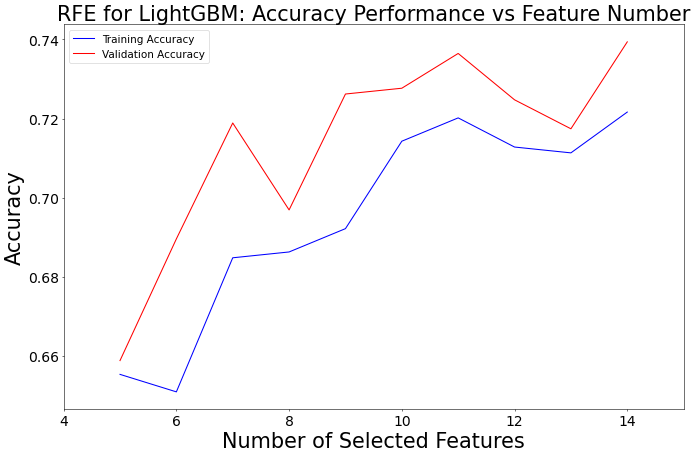

In [8]:
plot_performances( "LightGBM", nums, val_accs, test_accs ) 